In [1]:
import datetime
import itertools
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.optimize import minimize
import seaborn as sns

data = pd.read_csv("data/sp500_10.2013-10.2018.csv", index_col="Date")

# organize DataSeries
date = data.index
tLen = len(data)
time = np.linspace(0, tLen-1, tLen)
close = [data["Adj Close"][i] for i in range(len(data["Adj Close"]))]
DataSeries = [time, close]

data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-22,2773.939941,2778.939941,2749.219971,2755.879883,2755.879883,3307140000
2018-10-23,2721.030029,2753.590088,2691.429932,2740.689941,2740.689941,4348580000
2018-10-24,2737.870117,2742.590088,2651.889893,2656.100098,2656.100098,4709310000
2018-10-25,2674.879883,2722.699951,2667.840088,2705.570068,2705.570068,4634770000
2018-10-26,2667.860107,2692.379883,2628.159912,2658.689941,2658.689941,4803150000


## What I'm trying to do...
I am trying to fit the LPPL model to an S&P 500 dataset using the new fitting method outlined in section IV of [this paper](https://arxiv.org/pdf/1108.0099.pdf). The model can currently be fit to a dataset using a metaheuristic such as taboo search or genetic algorithm. However, in the paper linked to above, the researchers modified the model so as to avoid the use of metaheuristics in fitting the algorithm. Below has more info about the LPPL model; it is paraphrased from the paper.  

___

## The LPPL Model
The LPPL model provides a flexible framework to detect bubbles and predict regime changes of a financial asset. A bubble is defined as a faster-than-exponential increase in asset price, that reflects positive feedback loop of higher return anticipations competing with negative feedback spirals of crash expectations. It models a bubble price as a power law with a finite-time singularity decorated by oscillations with a frequency increasing with time. Here is an example of the LPPL model fitted to the Hang Seng Index from ~87-89.


<img src="images/hang_seng_index_87-89.png" alt="Hang Seng Index 87-89" width="500"/>


Here is the model:

$$E[\text{ln }p(t)] = A + B(t_c - t)^m + C(t_c - t)^m cos(\omega ln(t_c - t) - \phi) \tag{1}$$

where:

- $E[\text{ln }p(t)] :=$ expected log price at the date of the termination of the bubble
- $t_c :=$ critical time (date of termination of the bubble and transition in a new regime) 
- $A :=$ expected log price at the peak when the end of the bubble is reached at $t_c$
- $B :=$ amplitude of the power law acceleration
- $C :=$ amplitude of the log-periodic oscillations
- $m :=$ degree of the super exponential growth
- $\omega :=$ scaling ratio of the temporal hierarchy of osciallations
- $\phi :=$ time scale of the oscillations

The model has three components representing a bubble. The first, $A + B(t_c - t)^m$, handles the hyperbolic power law. For $m < 1$ when the price growth becomes unsustainable, and at $t_c$ the growth rate becomes infinite. The second term, $C(t_c - t)^m$, controls the amplitude of the oscillations. It drops to zero at the critical time $t_c$. The third term, $cos(\omega ln(t_c - t) - \phi)$, models the frequency of the osciallations. They become infinite at $t_c$.

___

## Fitting Procedure

The LPPL model has 4 non-linear parameters $(t_c,m,\omega,\phi)$ and 3 linear parameters $(A,B,C)$. They should be chosen with the goal to minimize the difference between the predicted values of the model $ln(\hat{p})$ and the real value $ln(p)$. This repersents a minimization problem with 3 linear and 4 non-linear parameters which have to be found. To decrease complexity of this task, equation (1) is rewritten. For this, two new parameters are introduced:

$$C_1 = C cos\phi, C_2 = C sin\phi \tag{2}$$

and now the equation (1) can be rewritten as:

$$\text{ln }E[p(t)] = A+B(t_c-t)^{m}+C_1(t_c-t)^{m}cos(\omega ln(t_c-t))+C_2(t_c-t)^{m} sin(\omega ln(t_c-t)) \tag{3}$$

$$E[\text{ln }p(t)] = A + (t_c - t)^m\bigl(B + C_1\text{cos}(\omega\text{ ln}(t_c - t)) + C_2\text{sin}(\omega\text{ ln}(t_c - t))\bigr)$$

By doing so, the model (3) now has 3 non-linear $(t_c,\omega,m)$ and 4 linear parameters $(A,B,C_1,C_2)$. To estimate the parameters which are fitted to the time series the least squares method with the following cost function (4) is used.

$$F(t_c,m,\omega,A,B,C_1,C_2) = \sum_{i=1}^{N} \left[\text{ln }p(\tau_{i}) - A - B(t_c-\tau_{i})^{m} - C_1(t_c-\tau_{i})^{m} cos(\omega ln(t_c-\tau_{i})) - C_2(t_c-\tau_{i})^{m} sin(\omega ln(t_c-\tau_{i}))\right]^{2} \tag{4}$$

where:

- $\tau_1 = t_1$
- $\tau_N = t_2$

Slaving the 4 linear parameters $A, B, C_1, C_2$ to the 3 nonlinear $t_c, \omega, m$ we obtain the nonlinear
optimization problem

$$\{\hat{t_c},\hat{m},\hat{\omega}\} = arg \min\limits_{t_c,m,\omega} F_1(t_c,m,\omega), \tag{5}$$

where the cost function $F_1(t_c,m,\omega)$ is given by

$$F_1(t_c,m,\omega) = \min\limits_{A,B,C_1,C_2} F(t_c,m,\omega,A,B,C_1,C_2) \tag{6}$$ 

The optimization problem $(\{\hat{A},\hat{B},\hat{C_1},\hat{C_2}\} = \text{arg} \min_{A,B,C_1,C_2} F(t_c,m,\omega,A,B,C_1,C_2))$ has a unique solution obtained from the matrix equation:


$$
    \begin{pmatrix}
        N & \sum{f_i} & \sum{g_i} & \sum{h_i}\\ 
        \sum{f_i} & \sum{f_i^{2}} & \sum{f_i g_i} & \sum{f_i h_i}\\
        \sum{g_i} & \sum{f_i g_i} & \sum{g_i^{2}} & \sum{g_i h_i}\\
        \sum{h_i} & \sum{f_i h_i} & \sum{g_i h_i} & \sum{h_i^{2}}\\
    \end{pmatrix}
    \begin{pmatrix}
        \hat{A}\\ 
        \hat{B}\\
        \hat{C_1}\\
        \hat{C_2}\\
    \end{pmatrix}
    =
    \begin{pmatrix}
        \sum{y_i}\\ 
        \sum{y_i f_i}\\
        \sum{y_i g_i}\\
        \sum{y_i h_i}\\
    \end{pmatrix}
    \tag{7}
$$

where:

- $y_i = \text{ln } p(\tau_i)$
- $f_i = (t_c - \tau_i)^{m}$
- $g_i = (t_c - \tau_i)^{m} cos(\omega \text{ln }(t_c-\tau_i))$
- $h_i = (t_c - \tau_i)^{m} sin(\omega \text{ln }(t_c-\tau_i))$

converting the matrix equation to a linear system:

$$\Bigl(N\cdot\hat{A}\Bigr) + 
\Bigl(\sum{f_i}\cdot\hat{B}\Bigr) + 
\Bigl(\sum{g_i}\cdot\hat{C_1}\Bigr) + \Bigl(\sum{h_i}\cdot\hat{C_2}\Bigr)=\sum{y_i}$$

$$\Bigl(\sum{f_i}\cdot\hat{A}\Bigr) + 
\Bigl(\sum{f_i^{2}}\cdot\hat{B}\Bigr) + 
\Bigl(\sum{f_i g_i}\cdot\hat{C_1}\Bigr) + 
\Bigl(\sum{f_i h_i}\cdot\hat{C_2}\Bigr)=\sum{y_i f_i}$$

$$\Bigl(\sum{g_i}\cdot\hat{A}\Bigr) + 
\Bigl(\sum{f_i g_i}\cdot\hat{B}\Bigr) + 
\Bigl(\sum{g_i^{2}}\cdot\hat{C_1}\Bigr) + 
\Bigl(\sum{g_i h_i}\cdot\hat{C_2}\Bigr)=\sum{y_i g_i}$$

$$\Bigl(\sum{h_i}\cdot\hat{A}\Bigr) + 
\Bigl(\sum{f_i h_i}\cdot\hat{B}\Bigr) + 
\Bigl(\sum{g_i h_i}\cdot\hat{C_1}\Bigr) + 
\Bigl(\sum{h_i^{2}}\cdot\hat{C_2}\Bigr)=\sum{y_i h_i}$$


and solve for $A, B, C_1, C_2$:

1. find the determinant of:

    \begin{pmatrix}
        N & \sum{f_i} & \sum{g_i} & \sum{h_i}\\ 
        \sum{f_i} & \sum{f_i^{2}} & \sum{f_i g_i} & \sum{f_i h_i}\\
        \sum{g_i} & \sum{f_i g_i} & \sum{g_i^{2}} & \sum{g_i h_i}\\
        \sum{h_i} & \sum{f_i h_i} & \sum{g_i h_i} & \sum{h_i^{2}}\\
    \end{pmatrix}
    
___

## Here's what I have so far...

In [2]:
# revised version of the LPPL without φ
# found on page 11 as equation (13)
def lppl(t, x):
    # non-linear should be estimated by least squares equation
    tc = x[0]
    m  = x[1]
    w  = x[2]
    # linear: should be given by matrix equation
    a  = x[3] 
    b  = x[4]
    c1 = x[5]
    c2 = x[6]
    return a + np.power(tc - t, m) * (b + ((c1 * np.cos(w * np.log(tc - t))) + (c2 * np.sin(w * np.log(tc - t)))))


# minimization func
def func(x):
    delta = [lppl(t,x) for t in DataSeries[0]]
    delta = np.subtract(delta, DataSeries[1])
    delta = np.power(delta, 2)
    return np.sum(delta)


# # set limits for minimization func
# limits = (
# #     [2658.67, 2658.71],   # A : plus or minus price at Critical Time ???
# #     [-1, -0.1],           # B :  B < 0
#     [tLen-(tLen*0.2), tLen+(tLen*0.2)],      # Critical Time :
#     [0.1, 0.9],           # m : 0.1 ≤ m ≤ 0.9
#     [6, 13],              # ω : 6 ≤ ω ≤ 13
# #     [0, np.cos(2*np.pi)], # c1 : |c1| < 1 ???
# #     [0, np.sin(2*np.pi)], # c2 : |c2| < 1 ???
# )

In [60]:
def _yi():
    return [np.log(p) for p in DataSeries[1]]

def _fi(tc_tau, m):
    return np.power(tc_tau, m)

def _gi(tc_tau, m, w):
    return np.multiply(
        _fi(tc_tau, m), 
        np.cos(np.multiply([w] * len(tc_tau), np.log(tc_tau)))
    )

def _hi(tc_tau, m, w):
    return np.multiply(
        _fi(tc_tau, m), 
        np.sin(np.multiply([w] * len(tc_tau), np.log(tc_tau)))
    )

def _fi_pow_2(tc_tau, m):
    return np.power(_fi(tc_tau, m), 2)

def _gi_pow_2(tc_tau, m, w):
    return np.power(_gi(tc_tau, m, w), 2)

def _hi_pow_2(tc_tau, m, w):
    return np.power(_hi(tc_tau, m, w), 2)

def _figi(tc_tau, m, w):
    return np.multiply(_fi(tc_tau, m), _gi(tc_tau, m, w))

def _fihi(tc_tau, m, w):
    return np.multiply(_fi(tc_tau, m), _hi(tc_tau, m, w))

def _gihi(tc_tau, m, w):
    return np.multiply(_gi(tc_tau, m, w), _hi(tc_tau, m, w))

def _yifi(tc_tau, m):
    return np.multiply(_yi(), _fi(tc_tau, m))

def _yigi(tc_tau, m, w):
    return np.multiply(_yi(), _gi(tc_tau, m, w))

def _yihi(tc_tau, m, w):
    return np.multiply(_yi(), _hi(tc_tau, m, w))

size = 5
N = tLen
tc_tau = [tLen - t for t in DataSeries[0]]
solutions = []

for i in range(size):
    print("Running {}".format(i))
    
    # set limits for minimization func
    limits = (
        [tLen-(tLen*0.2), tLen+(tLen*0.2)],    # Critical Time + or - .2
        [0.1, 0.9],                            # m : 0.1 ≤ m ≤ 0.9
        [6, 13],                               # ω : 6 ≤ ω ≤ 13     
    )   
    non_lin_vals = [random.uniform(a[0], a[1]) for a in limits]

    tc = non_lin_vals[0]
    m = non_lin_vals[1]
    w = non_lin_vals[2]
    
    # do the matrix equation here...
    fi = np.sum(_fi(tc_tau, m))
    gi = np.sum(_gi(tc_tau, m, w))
    hi = np.sum(_hi(tc_tau, m, w))
    fi_pow_2 = np.sum(_fi_pow_2(tc_tau, m))
    gi_pow_2 = np.sum(_gi_pow_2(tc_tau, m, w))
    hi_pow_2= np.sum(_hi_pow_2(tc_tau, m, w))
    figi = np.sum(_figi(tc_tau, m, w))
    fihi = np.sum(_fihi(tc_tau, m, w))
    gihi = np.sum(_gihi(tc_tau, m, w))
    
    yi = np.sum(_yi())
    yifi = np.sum(_yifi(tc_tau, m))
    yigi = np.sum(_yigi(tc_tau, m, w))
    yihi = np.sum(_yihi(tc_tau, m, w))
    
    matrix_1 = np.matrix([
        [N,  fi,       gi,       hi      ],
        [fi, fi_pow_2, figi,     fihi    ],
        [gi, figi,     gi_pow_2, gihi    ],
        [hi, fihi,     gihi,     hi_pow_2]
    ])
    
    matrix_2 = np.matrix([
        [yi],
        [yifi],
        [yigi],
        [yihi]
    ])

    inv = np.linalg.inv(matrix_1)
    product = inv * matrix_2
    
    lin_vals = [i[0] for i in product.tolist()]
    
    a = lin_vals[0]
    b = lin_vals[1]
    c1 = lin_vals[2]
    c2 = lin_vals[3]
    
    print((a,b,c1,c2))
    
#     print(matrix_1)
#     print(matrix_2)
#     print(inv)
#     print(product)
#     print("-------------")
    
    seed = [tc,m,w,a,b,c1,c2]
    
    # scipy optimize minimize
    # Minimize a function with variables subject to bounds, using gradient information in a truncated Newton algorithm. 
    # This method wraps a C implementation of the algorithm.
    cofs = minimize(fun=func, x0=seed, method='Nelder-Mead', options={'maxfev': 7*500})
    
    # add to result for use in matrix equation ???
    if cofs.success:
        solutions.append({
            'fit': func(cofs.x),
            'cof': cofs.x
        })
    print("Success: {}\nMessage: {}".format(cofs.success, cofs.message))
    print("Number of iterations: {}".format(cofs.nit))
    print("Number of evaluations of obj funcs: {}".format(cofs.nfev))
    print("-"*25)
print(solutions)

Running 0
(1250.042769580066, -0.0014069342201565123, -0.0001107470623860924, -1.6026642370161118e-05)
[[     1258.      231840.59     -3432.61    -39223.96]
 [   231840.59  53482451.     -172690.85 -12954828.63]
 [    -3432.61   -172690.85  25476172.99  -3061689.8 ]
 [   -39223.96 -12954828.63  -3061689.8   28006278.01]]
[[   9685.02]
 [1769789.44]
 [ -29843.47]
 [-293997.25]]
[[ 0. -0.  0. -0.]
 [-0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [-0.  0.  0.  0.]]
[[ 7.96]
 [-0.  ]
 [-0.  ]
 [-0.  ]]
-------------


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in power
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 389
Number of evaluations of obj funcs: 3500
-------------------------
Running 1
(1249.8065741169014, -0.060260739132529204, 0.0007051684447070827, -0.0027563851688538754)
[[ 1258.   10296.3    773.61   867.91]
 [10296.3  89902.53  8138.08  9665.36]
 [  773.61  8138.08 41773.89   127.97]
 [  867.91  9665.36   127.97 48128.64]]
[[ 9685.02]
 [78923.5 ]
 [ 5877.19]
 [ 6396.12]]
[[ 0.01 -0.    0.    0.  ]
 [-0.    0.   -0.   -0.  ]
 [ 0.   -0.    0.    0.  ]
 [ 0.   -0.    0.    0.  ]]
[[ 8.19]
 [-0.06]
 [ 0.  ]
 [-0.  ]]
-------------


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in cos
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sin
  del sys.path[0]


Success: True
Message: Optimization terminated successfully.
Number of iterations: 1069
Number of evaluations of obj funcs: 1958
-------------------------
Running 2
(1250.0514941394015, -0.0011409490692557175, 5.760618997411107e-06, -6.376768620361059e-05)
[[    1258.     274177.44    31128.      24416.81]
 [  274177.44 75451162.59 11683917.44 10447446.04]
 [   31128.   11683917.44 34095425.19  1640096.85]
 [   24416.81 10447446.04  1640096.85 41355737.4 ]]
[[   9685.02]
 [2092616.16]
 [ 234182.16]
 [ 179529.42]]
[[ 0. -0.  0.  0.]
 [-0.  0. -0. -0.]
 [ 0. -0.  0.  0.]
 [ 0. -0.  0.  0.]]
[[ 7.95]
 [-0.  ]
 [ 0.  ]
 [-0.  ]]
-------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 2231
Number of evaluations of obj funcs: 3488
-------------------------
Running 3
(1250.05430366602, -0.0009445456112838089, -7.493967813020758e-05, -2.2277748906717257e-05)
[[ 1.26e+03  3.30e+05  5.17e+02 -5.76e+04]
 [ 3.30e+05  1.11e+08  2.43e+06 -2.77e+07]
 [ 5.17e+0

123647430.30205803
115114141.38693058


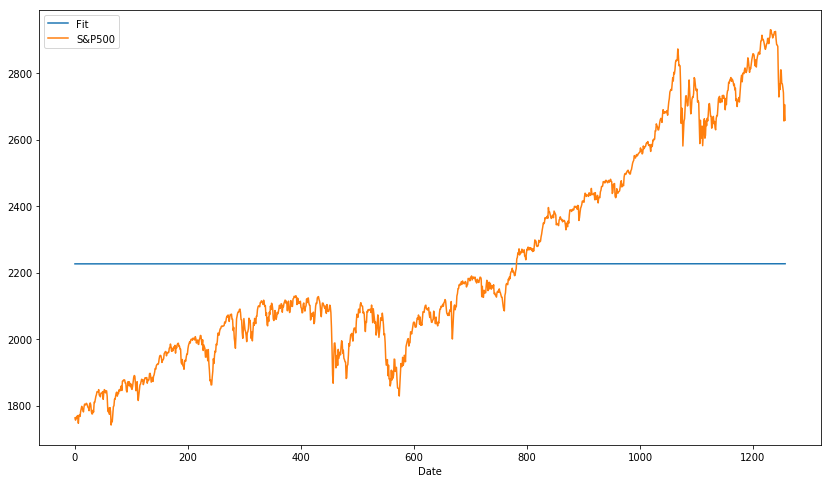

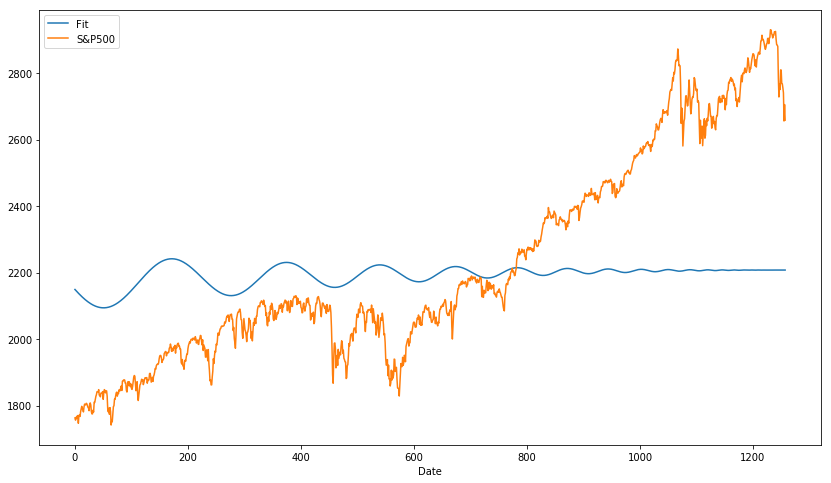

In [61]:
for i in solutions:
    print(i["fit"])
    lppl_fit = [lppl(t,i['cof']) for t in DataSeries[0]]
    price_data = DataSeries[1]
    
    data = pd.DataFrame({
        'Date': DataSeries[0],
        'Fit': lppl_fit,
        'S&P500': price_data,
    })
    data = data.set_index('Date')
    data.plot(figsize=(14,8))